#### Flood Depth Prediction across the Contiguous United States using Multimodal Earth Observation Data and Machine Learning
This notebook shows the pipeline for training a machine learning model for predicting flood depths across the CONUS. 

### Datasets and Predictors
- [Digital Elevation Model at 10m and 1m](https://www.usgs.gov/3d-elevation-program)
- [National Land Cover Dataset Impervious Surfaces](https://www.usgs.gov/centers/eros/science/annual-national-land-cover-database)  
- [CHIRPS Precipitation](https://www.chc.ucsb.edu/data/chirps)
- [Sentinel 1 VV and VH](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)
- [USGS High Water Mark Height](https://www.usgs.gov/water-science-school/science/high-water-marks-and-flooding)
- [Soil Moisture Active Passive](https://developers.google.com/earth-engine/tutorials/community/smap-soil-moisture)
- [Weather Parameters](https://www.weatherapi.com/)
    - Humidity 
    - Dewpoint Temperature
    - Wind Direction (UV)
    - Wind Gust (kPh)
    - Feels Like Temperature
    - Wind Chill
    - Heat Index
    - Chance of Rain
    - Chance of Snow
    - Visibiltiy (km)

Import necessary packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from utils import (split_dataset, 
                    z_normalize, 
                    calculate_regression_metrics, 
                    plot_actual_vs_predicted,
                    plot_residuals,
                    feature_importance_analysis,
                    plot_importances,
                    plot_cumulative_importances,
                    )

RANDOM_STATE=54

### Data Preparation
Load and prepare datasets for modelling

In [2]:
df_wlabs = pd.read_csv("data/combined_features_without_Sentinel.csv")
df = df_wlabs.drop(columns=['ID'])

X = df.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
y = df['height_above'].values
indices = np.arange(len(X))
# np.random.shuffle(indices)
X = X[indices]
y = y[indices]

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Final feature matrix shape: (1147, 49)
Target variable shape: (1147,)


In [3]:
# split datasets in train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test  = split_dataset(X, y, test_size=0.3, random_state=RANDOM_STATE)

Number of training observations: 802 (69.9%)
Number of validation observations: 172 (15.0%)
Number of test observations: 173 (15.1%)


In [4]:
#z-normalize datasets across splits 
X_train_norm, X_val_norm, X_test_norm = z_normalize(X_train, X_val, X_test)

/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:29: RuntimeWarning: invalid value encountered in divide
  X_train_norm = (X_train - X_mean) / X_std
/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:30: RuntimeWarning: invalid value encountered in divide
  X_val_norm = (X_val - X_mean) / X_std
/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:31: RuntimeWarning: invalid value encountered in divide
  X_test_norm = (X_test - X_mean) / X_std


### Modelling
Hyperparameter tuning and training of the Random Forest Model

In [5]:
# Robust Hyperparameter Tuning with Cross-Validation
rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Parameter grid for regression
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Cross-validation for regression
rf_cv = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=100,  # More iterations for better search
    cv=5,       # 10-fold CV for more robust evaluation
    scoring='neg_mean_squared_error',  # MSE for regression
    random_state=RANDOM_STATE,
    n_jobs=-1,   # Use all cores
    verbose=1
)

print("Starting hyperparameter optimization...")
rf_optimized = rf_cv.fit(X_train_norm, y_train)

print('Best parameters:', rf_optimized.best_params_)
print('Best cross-validation score (neg_MSE):', rf_optimized.best_score_)

Starting hyperparameter optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best cross-validation score (neg_MSE): -0.291250406505755


### Model Evaluation

In [6]:
# Model Evaluation on All Sets
best_rf = rf_optimized.best_estimator_
# Predictions on all sets
y_train_pred = best_rf.predict(X_train_norm)
y_val_pred = best_rf.predict(X_val_norm)
y_test_pred = best_rf.predict(X_test_norm)
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Calculate metrics for all sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_regression_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test")

MODEL PERFORMANCE METRICS

Training Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.0465
Root Mean Squared Error (RMSE): 0.2156
Mean Absolute Error (MAE): 0.1481
R² Score: 0.9075

Validation Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.3308
Root Mean Squared Error (RMSE): 0.5751
Mean Absolute Error (MAE): 0.3782
R² Score: 0.2501

Test Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.2467
Root Mean Squared Error (RMSE): 0.4967
Mean Absolute Error (MAE): 0.3505
R² Score: 0.5101


Actual versus Predicted

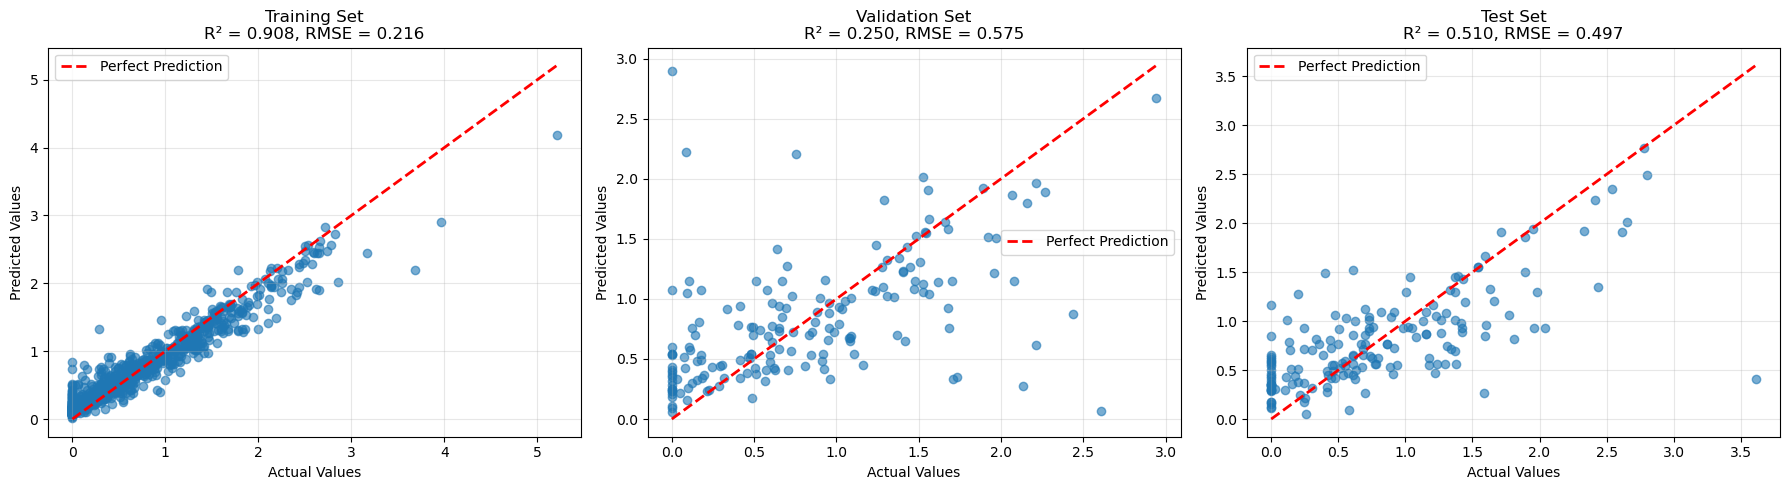

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_actual_vs_predicted(y_train, y_train_pred, axes[0], 'Training', train_metrics)
plot_actual_vs_predicted(y_val, y_val_pred, axes[1], 'Validation', val_metrics)
plot_actual_vs_predicted(y_test, y_test_pred, axes[2], 'Test', test_metrics)

plt.tight_layout()
plt.show()

Residual Plots

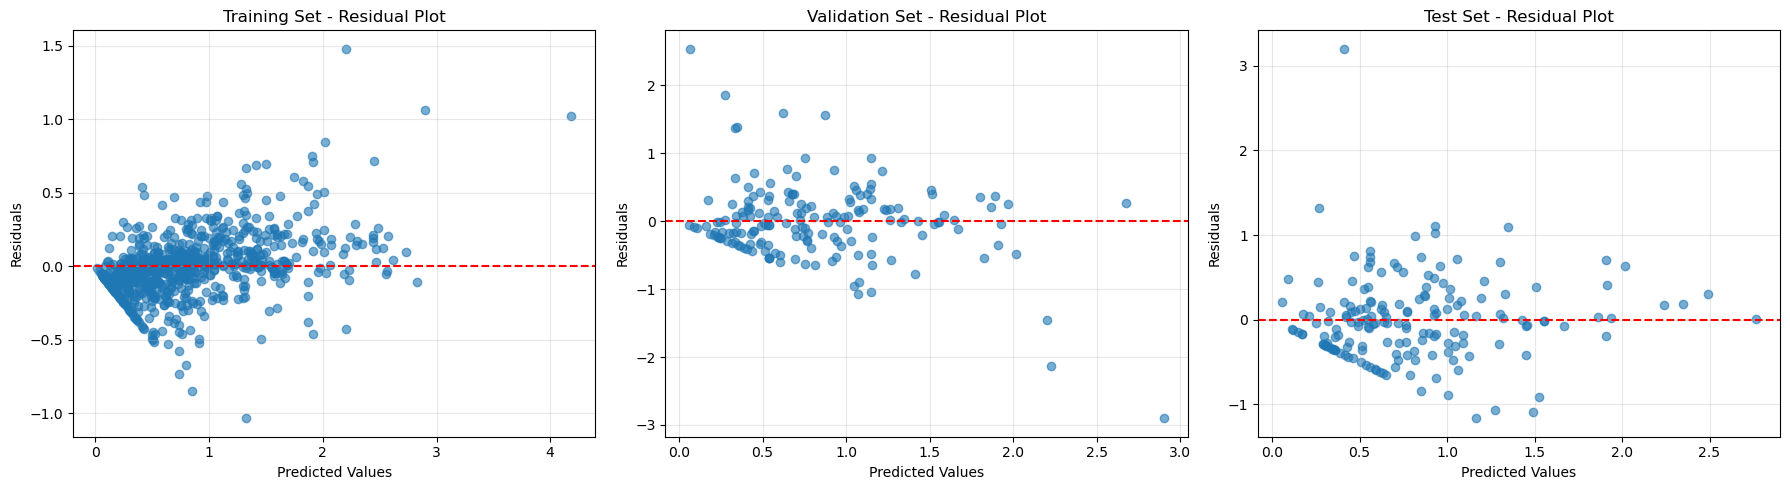

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_residuals(y_train, y_train_pred, axes[0], 'Training')
plot_residuals(y_val, y_val_pred, axes[1], 'Validation')
plot_residuals(y_test, y_test_pred, axes[2], 'Test')

plt.tight_layout()
plt.show()

#### Feature Importance Analysis

In [9]:
feature_importance, importance_df = feature_importance_analysis(best_rf, df)
importance_df

,feature,importance
24,area_km_wetlands,0.045126
29,latitude,0.044032
28,longitude,0.039825
36,dewpoint_c,0.038829
39,feelslike_c,0.037692
33,pressure_mb,0.036788
7,area_km_1,0.032852
23,pct_area_wetlands,0.032478
3,dem_iqr,0.032063
8,area_km_2,0.030277


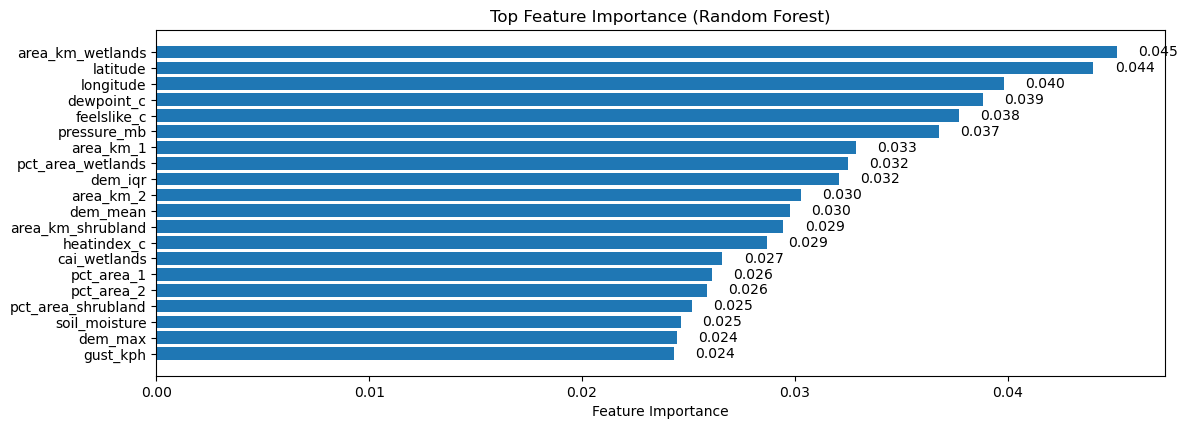

In [10]:
plot_importances(importance_df)

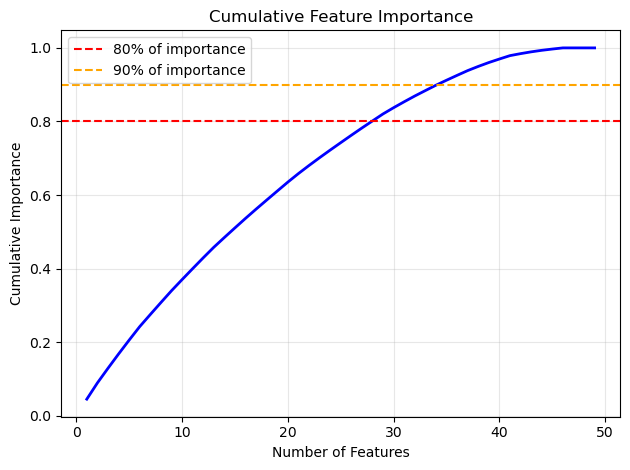

In [11]:
plot_cumulative_importances(importance_df)

In [12]:
cumulative_importance = np.cumsum(importance_df['importance'].values)
# Find number of features needed for 80% and 90% of importance
idx_80 = np.argmax(cumulative_importance >= 0.8) + 1
idx_90 = np.argmax(cumulative_importance >= 0.9) + 1

print(f"\nFeature Selection Insights:")
print(f"Number of features needed for 80% of importance: {idx_80}")
print(f"Number of features needed for 90% of importance: {idx_90}")
print(f"Total number of features: {len(feature_importance)}")

# Save feature importance to CSV
importance_path = r'data/rf_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"\nFeature importance saved to: {importance_path}")


Feature Selection Insights:
Number of features needed for 80% of importance: 28
Number of features needed for 90% of importance: 35
Total number of features: 49

Feature importance saved to: data/rf_feature_importance.csv


#### Model Summary

In [13]:
# Final Model Summary
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best Random Forest Parameters: {rf_optimized.best_params_}")
print(f"Best Cross-Validation Score (neg_MSE): {rf_optimized.best_score_:.4f}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  MSE: {test_metrics['mse']:.4f}")

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Training R²: {train_metrics['r2']:.4f}")
print(f"  Validation R²: {val_metrics['r2']:.4f}")
print(f"  Test R²: {test_metrics['r2']:.4f}")
print(f"  Train-Val R² Gap: {train_metrics['r2'] - val_metrics['r2']:.4f}")
print(f"  Train-Test R² Gap: {train_metrics['r2'] - test_metrics['r2']:.4f}")

if train_metrics['r2'] - test_metrics['r2'] > 0.2:
    print("  WARNING: Potential overfitting detected (>20% R² gap between train and test)")
else:
    print("  Model shows good generalization")

print("\n" + "="*80)

FINAL MODEL SUMMARY
Best Random Forest Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best Cross-Validation Score (neg_MSE): -0.2913

Final Test Set Performance:
  R² Score: 0.5101
  RMSE: 0.4967
  MAE: 0.3505
  MSE: 0.2467

Overfitting Check:
  Training R²: 0.9075
  Validation R²: 0.2501
  Test R²: 0.5101
  Train-Val R² Gap: 0.6574
  Train-Test R² Gap: 0.3975



#### Extract residuals with IDs for all data splits

In [14]:
# Extract residuals with IDs for all data splits
print("="*60)
print("EXTRACTING RESIDUALS WITH IDs")
print("="*60)

# We need to reconstruct the full dataset with predictions to get residuals with IDs
# First, let's get predictions for the entire dataset
full_X = df.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
full_y = df_wlabs['height_above'].values
original_ids = df_wlabs['ID'].values

# Standardize the full dataset using training statistics (same as used for model training)
X_mean = np.nanmean(X_train, axis=0)
X_std = np.nanstd(X_train, axis=0)
full_X_norm = (full_X - X_mean) / X_std

# Get predictions for all samples
full_predictions = best_rf.predict(full_X_norm)

# Calculate residuals (actual - predicted)
residuals = full_y - full_predictions

# Create residuals dataframe with IDs
residuals_df = pd.DataFrame({
    'ID': original_ids,
    'Actual_height_above': full_y,
    'Predicted_height_above': full_predictions,
    'Residual': residuals,
    'Absolute_Residual': np.abs(residuals)
})

# Sort by ID for easier analysis
residuals_df = residuals_df.sort_values('ID')

# Display basic statistics
print(f"Total samples: {len(residuals_df)}")
print(f"Mean residual: {residuals_df['Residual'].mean():.4f}")
print(f"Std residual: {residuals_df['Residual'].std():.4f}")
print(f"Mean absolute residual: {residuals_df['Absolute_Residual'].mean():.4f}")

# Show first few rows
print(f"\nFirst 10 rows of residuals:")
print(residuals_df.head(10))

# Save to CSV
output_path = 'data/rf_residuals.csv'
residuals_df.to_csv(output_path, index=False)
print(f"\nResiduals saved to: {output_path}")

# Additional analysis: identify largest residuals
print(f"\nTop 10 largest positive residuals (model under-predicted):")
print(residuals_df.nlargest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest negative residuals (model over-predicted):")
print(residuals_df.nsmallest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest absolute residuals:")
print(residuals_df.nlargest(10, 'Absolute_Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

EXTRACTING RESIDUALS WITH IDs
Total samples: 1147
Mean residual: -0.0056
Std residual: 0.3455
Mean absolute residual: 0.2132

First 10 rows of residuals:
       ID  Actual_height_above  Predicted_height_above  Residual  \
966   770             1.539240                1.554988 -0.015748   
1020  771             1.690624                1.684569  0.006055   
560   772             1.690624                1.656812  0.033812   
1126  773             1.539240                1.554988 -0.015748   
102   774             1.539240                1.554988 -0.015748   
711   775             1.539240                1.554988 -0.015748   
572   776             1.690624                1.656812  0.033812   
468   777             1.690624                1.684569  0.006055   
352   778             1.539240                1.554988 -0.015748   
1022  779             1.539240                1.554988 -0.015748   

      Absolute_Residual  
966            0.015748  
1020           0.006055  
560            0.03

/tmp/ipykernel_4158366/3487678392.py:15: RuntimeWarning: invalid value encountered in divide
  full_X_norm = (full_X - X_mean) / X_std


### Contributors
- Parnian Ghaneei
- Xiao Chen
- Jinkun Liu
- Temitope Akinboyewa
- Rufai Omowunmi Balogun
- Aleksander Berg
- Wen Zhou, PhD.